<a href="https://colab.research.google.com/github/Victor1992/SlkimLit_nlp_milestone_project/blob/main/SlkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project NLP: SkimLit

The purpose of this notebook is to build an NLP model to make reading abstracts easier.

The paere we will be replicating (the source of the dataset that we'll be using) is availaible here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that teh model architecture that they use to achieve their best results is availaible here: https://arxiv.org/abs/1612.05251



## Confirm Access to GPU

In [1]:
!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-595de73e-c1ab-40e9-b3f9-afe879f1a05f)


## Get Data

Since we are replicating the paper above (PubMed 200K), let's download the dataset.

We can do from author github:https://github.com/Franck-Dernoncourt/pubmed-rct


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using  the 20K dataset with numbers replaced by @sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all our file names in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

In [6]:
# Function to read the lines of a document
def get_lines(filename_path):
  """
  Reads a filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename_path, "r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Format we want our data to look...

```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines':11},
     ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename_path):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename path, reads it contents and sorts through each line,
  extratcing things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename_path) # get all file from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if(line.startswith("###")): # check to see if the line is an ID line 
      abstract_id = line
      abstract_lines = ""   # Reset abstract string if the line is an ID line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what the number line the target text apperar in the abstarct
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines in the target abstract? 
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line conatins a labelled sentence
      abstract_lines += line

  return abstract_samples




In [10]:
# Get data from file and preprocess
%%time

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+ "dev.txt") # dev is another name for validation
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 956 ms, sys: 138 ms, total: 1.09 s
Wall time: 1.72 s


In [11]:
# Check the forst abstract of our training data
train_samples[:16]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data in in the form of dictionary hwo about we turn it into dataframe to further visualize it

In [12]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

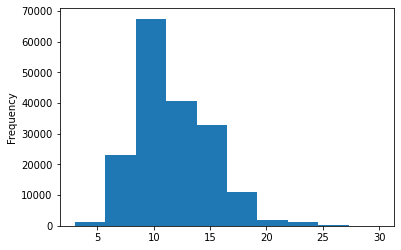

In [14]:
train_df.total_lines.plot.hist();

## Get list of sentences

In [15]:
# Convert abstract text lines into list
train_sentences  = train_df["text"].tolist()
val_sentences =  val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# view 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels()

### One hot Encoder

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # tensorflow is incompatible with sparse matrix so we put sparse=False 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [19]:
# extract labels ( target columsn) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes in Labelencoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

We will try out a bunch of different models and seeing which one works best



### Model 0: TF-IDF Multinomial naive Bayes classifier

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

# Fit the model
model_0.fit(X = train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# evaluate the model
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make Predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Function to calculate : accuracy, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score

  Args:
    y_true: true labels in the form of 1d array
    y_pred: predicted labels in the form of a 1d array
  
  Returns a dictionary of accuracy, precision, recall, f1-score
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 using "weighted average"
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = { "accuracy": model_accuracy,
                   "precision" : model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [25]:
# Calculate Baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep sequence models

Before we start building our deeper models, we'he got to craete vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long the sentence is on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

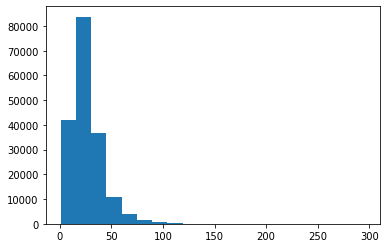

In [28]:
# what's the ditrinbution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [29]:
# How long of a sentecne length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Max seq length in the training set
max(sent_lens)

296

### Create text vectorizer layer

Layer which maps our text from words to numbers

In [31]:
# How many words are in our vocab? (taken from tabel 2 in: https://arxiv.org/pdf/1710.06071.pdf)

max_tokens = 68000

In [32]:
# Create text Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in  vocab
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [33]:
# Adapt tect vectorizer to tarining setences

text_vectorizer.adapt(train_sentences)

In [34]:
# Text our tect vectorozer on random sentence
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
patients ( american society of anesthesiologists physical status i to ii ) undergoing l-i were randomly assigned to receive anesthesia with propofol and remifentanil under @ remifentanil dose conditions : @ g/kg/minute ( group @ ) , @ g/kg/minute ( group @ ) , and @ g/kg/minute ( group @ ) .

Length of text: 292

Vectorized text: [[   12  1035  1702     4  3542   189   272   389     6   378   295  2494
      9    92   123     6   175   435     7   914     3  1442   353  1442
    131   458 20569    13 20569    13     3 20569    13     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary

rct_20K_text_vocab  = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20K_text_vocab)}")
print(f"Most common words in the vocab:{rct_20K_text_vocab[:5]}")
print(f"Least common words in the vocab:{rct_20K_text_vocab[-5:]}")

Number of words in vocab:64841
Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Config of Tect Vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Creating text embedding layer

In [37]:
### Create custom text embedding
token_embed = layers.Embedding(input_dim=len(rct_20K_text_vocab),
                               output_dim=128,
                               mask_zero=True, # heplps to do more efficent computing when there are lots of zeros
                               name="token_embedding")


In [38]:
print(f"Sentence before vectorizer:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded Sentence shape:\n {embedded_sentence.shape}\n")



Sentence before vectorizer:
patients ( american society of anesthesiologists physical status i to ii ) undergoing l-i were randomly assigned to receive anesthesia with propofol and remifentanil under @ remifentanil dose conditions : @ g/kg/minute ( group @ ) , @ g/kg/minute ( group @ ) , and @ g/kg/minute ( group @ ) .

Sentence after vectorization (before embedding):
[[   12  1035  1702     4  3542   189   272   389     6   378   295  2494
      9    92   123     6   175   435     7   914     3  1442   353  1442
    131   458 20569    13 20569    13     3 20569    13     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00556852 -0.03948528  0.00813465 ... -0.00047404  0.02085382
    0.02729276]
  [-0.02328349  0.04032761  0.00273869 ... -0.02066436 -0.02532061
   -0.00881801]
  [ 0.00894485  0.04983285 -0.04196229 ... -0.01586946  0.02183637
    0.03266051]
  ...
  [ 

### Creating datasets (making sure our data loads as fast as posssible)

In [39]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))  

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [40]:
# Take the tensorflow's dataset and turn them into prefetched datasets

train_dataset =  train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset  = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


In [41]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings

In [42]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
x= layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 22ms/step - loss: 0.9112 - accuracy: 0.6390 - val_loss: 0.6846 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 10s 19ms/step - loss: 0.6594 - accuracy: 0.7537 - val_loss: 0.6313 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 11s 20ms/step - loss: 0.6206 - accuracy: 0.7731 - val_loss: 0.5995 - val_accuracy: 0.7836


In [45]:
# evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.6020 - accuracy: 0.7849


[0.60197913646698, 0.7848867774009705]

In [46]:
# Make redictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.4065577e-01, 2.0609243e-01, 8.3812661e-02, 2.3647098e-01,
         3.2968119e-02],
        [4.6343452e-01, 2.7992713e-01, 1.4082979e-02, 2.3299280e-01,
         9.5625771e-03],
        [1.4215595e-01, 6.6370163e-03, 2.7730900e-03, 8.4836900e-01,
         6.4971806e-05],
        ...,
        [3.4439909e-06, 7.7528355e-04, 7.3585025e-04, 1.8829734e-06,
         9.9848360e-01],
        [4.7997106e-02, 4.7076973e-01, 9.5214635e-02, 5.4093432e-02,
         3.3192500e-01],
        [1.8902829e-01, 6.3501018e-01, 3.8723867e-02, 5.7177346e-02,
         8.0060333e-02]], dtype=float32), (30212, 5))

In [47]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds) 

In [49]:
model_1_results

{'accuracy': 78.48867999470409,
 'f1': 0.7822923703955248,
 'precision': 0.7814856411754566,
 'recall': 0.7848867999470409}

In [50]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 2: Feature extraction with pretrained token embeddings



In [51]:
# Download pretrained Tensorflow h-Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [52]:
import random 
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentences:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:10]}\n")
print(f"Length of sentence embedding:{len(use_embedded_sentence[0])}")


Random Sentences:
standardized assessments of cognitive function were collected an average of @ years after trial enrollment .
Sentence after embedding:
[ 0.01732415 -0.06589028 -0.02592959 -0.02025259 -0.07209959 -0.01598032
 -0.00028945  0.00810191 -0.03372955  0.06356539]

Length of sentence embedding:512


Building and fitting an NLP extraction model using pretrained embeddings

In [53]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation = "relu")(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss= "categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [55]:
# Fir the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1* len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9177 - accuracy: 0.6501 - val_loss: 0.7960 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7687 - accuracy: 0.7019 - val_loss: 0.7547 - val_accuracy: 0.6995
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7520 - accuracy: 0.7126 - val_loss: 0.7381 - val_accuracy: 0.7104


In [56]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 27s 29ms/step - loss: 0.7404 - accuracy: 0.7146


[0.7403576374053955, 0.7146167159080505]

In [57]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.4337713 , 0.35609353, 0.00211966, 0.20100904, 0.00700639],
       [0.36463025, 0.47255465, 0.00327924, 0.15690732, 0.0026285 ],
       [0.2390183 , 0.16398783, 0.01649228, 0.54334533, 0.03715627],
       ...,
       [0.00152137, 0.00594545, 0.05461829, 0.00098859, 0.93692625],
       [0.00374574, 0.04432949, 0.20238312, 0.0014774 , 0.7480642 ],
       [0.15859923, 0.37478533, 0.40353817, 0.00802073, 0.05505652]],
      dtype=float32)

In [58]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) 
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [59]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 71.46167085926122,
 'f1': 0.711497406285783,
 'precision': 0.715031593151931,
 'recall': 0.7146167085926122}

In [60]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Model 3: Conv1D with character level embeddings

The paper which we're replicating states they used a combination of token and character-level encodings.

Previously we've token= level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings

In [61]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [62]:
def split_chars(text):
  return " ".join(list(text))

In [63]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [64]:
# Split sequence level data splits into character level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars =  [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars[:5] 

['i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'i t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'w e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   .',
 'a s t h m a t i c   p a t i e n t s   w h o   w e r e   i g e   s e n s i t i z e d   t o   a   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [65]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

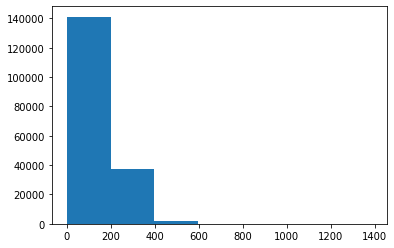

In [66]:
# Check the ditribution of our sequences at character level
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7);

In [67]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
random.choice(train_sentences)

'this paper reports on the use of @ forms of interaction ( reporting changes in quit status and emergency help ) among users of quittxt , an interactive , automated text messaging advice program .'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and token (OOV = out of vocab. '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length = output_seq_char_len,
                                 name="char_vectorizer")

In [71]:
# For learning purpose what happens when we set  standardize=None
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and token (OOV = out of vocab. '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                 output_sequence_length = output_seq_char_len,
                                 # standardize=None,
                                 name="char_vectorizer")

char_vectorizer.adapt(train_chars)

# Check charater voccab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diff  characters vocab: {len(char_vocab)} ")
print(f"5 most common charaters: {char_vocab[:5]}")
print(f"5 least common charaters: {char_vocab[-5:]}")

Number of diff  characters vocab: 28 
5 most common charaters: ['', '[UNK]', 'e', 't', 'i']
5 least common charaters: ['k', 'x', 'z', 'q', 'j']


In [72]:
# Adapt charater vectorizer to trainig character
char_vectorizer.adapt(train_chars)

In [73]:
# Check charater voccab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diff  characters vocab: {len(char_vocab)} ")
print(f"5 most common charaters: {char_vocab[:5]}")
print(f"5 least common charaters: {char_vocab[-5:]}")

Number of diff  characters vocab: 28 
5 most common charaters: ['', '[UNK]', 'e', 't', 'i']
5 least common charaters: ['k', 'x', 'z', 'q', 'j']


In [74]:
# Test our  charater vectorizer

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized Char:\n {vectorized_chars}")
print(f"\n Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   f i r s t   c o p r i m a r y   o u t c o m e   i s   @ - d a y   a l l - c a u s e   m o r t a l i t y   ,   a n d   t h e   m o s t   s e c o n d   c o p r i m a r y   o u t c o m e   i s   a   c o m p o s i t e   o f   d e a t h   ,   m i   ,   s t r o k e   ,   r e n a l   f a i l u r e   ,   o r   r e s p i r a t o r y   f a i l u r e   w i t h i n   @   d a y s   .
Length of random_train_chars: 381
\Vectorized Char:
 [[ 3 13  2 17  4  8  9  3 11  7 14  8  4 15  5  8 19  7 16  3 11  7 15  2
   4  9 10  5 19  5 12 12 11  5 16  9  2 15  7  8  3  5 12  4  3 19  5  6
  10  3 13  2 15  7  9  3  9  2 11  7  6 10 11  7 14  8  4 15  5  8 19  7
  16  3 11  7 15  2  4  9  5 11  7 15 14  7  9  4  3  2  7 17 10  2  5  3
  13 15  4  9  3  8  7 23  2  8  2  6  5 12 17  5  4 12 16  8  2  7  8  8
   2  9 14  4  8  5  3  7  8 19 17  5  4 12 16  8  2 20  4  3 13  4  6 10
   5 19  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  

### Creating a charater level embedding

In [75]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero = True,
                              name="char_embed"
                              )

In [76]:
# Test charater level embedding
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed Chars. (after vectorization and embedding):\n{char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   f i r s t   c o p r i m a r y   o u t c o m e   i s   @ - d a y   a l l - c a u s e   m o r t a l i t y   ,   a n d   t h e   m o s t   s e c o n d   c o p r i m a r y   o u t c o m e   i s   a   c o m p o s i t e   o f   d e a t h   ,   m i   ,   s t r o k e   ,   r e n a l   f a i l u r e   ,   o r   r e s p i r a t o r y   f a i l u r e   w i t h i n   @   d a y s   .

Embed Chars. (after vectorization and embedding):
[[[ 0.00306116 -0.03939752  0.02038553 ... -0.03290378 -0.04920581
    0.01074053]
  [-0.03968412  0.0017261  -0.04818472 ...  0.02352488 -0.02489183
    0.02296023]
  [ 0.02897045 -0.02720875  0.03425862 ... -0.02302262  0.03658784
    0.04245785]
  ...
  [ 0.01517158 -0.04754303 -0.04937058 ... -0.01662885  0.00955973
    0.03608148]
  [ 0.01517158 -0.04754303 -0.04937058 ... -0.01662885  0.00955973
    0.03608148]
  [ 0.01517158 -0.04754303 -0.04937058 ... -0.01662885  0.00955973
    0.03608148]]]
Character embedding shape: (1, 290, 25)


### Bulding a Conv1D model to fit on charater embeddings

In [77]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors)
x= layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,outputs= outputs, name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 

In [79]:
# Create char level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [80]:
# Fit the model on chars only

model_3_history =  model_3.fit(train_char_dataset,
                               steps_per_epoch=int(0.1 * len(train_char_dataset)),
                               epochs=3,
                               validation_data = val_char_dataset,
                               validation_steps = int(0.1* len(val_char_dataset))
                               )

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.4587 - accuracy: 0.3490 - val_loss: 1.4065 - val_accuracy: 0.4029
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.3674 - accuracy: 0.4222 - val_loss: 1.3337 - val_accuracy: 0.4395
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 1.3263 - accuracy: 0.4513 - val_loss: 1.3148 - val_accuracy: 0.4455


In [81]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.17020397, 0.2425502 , 0.2781557 , 0.16365795, 0.1454322 ],
       [0.10626136, 0.16558605, 0.15453611, 0.0648494 , 0.50876707],
       [0.0975851 , 0.15144892, 0.4479336 , 0.09578448, 0.20724785],
       ...,
       [0.06404475, 0.11181958, 0.23458531, 0.04169626, 0.54785407],
       [0.04691162, 0.09948901, 0.21577603, 0.04277673, 0.59504664],
       [0.13913658, 0.18002473, 0.20644175, 0.07155277, 0.4028442 ]],
      dtype=float32)

In [82]:
# Convert prediction probabalities to class labels
model_3_pred =  tf.argmax(model_3_pred_probs, axis=1)
model_3_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 4])>

In [83]:
model_3_results  =  calculate_results(y_true=val_labels_encoded,
                                      y_pred=model_3_pred)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.982126307427514,
 'f1': 0.3950117215898088,
 'precision': 0.3774148473038902,
 'recall': 0.4498212630742751}

### Model 4: Combining pretrained token level embeddings + character level embedings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a charater level model ( similar to `model_3`  with a slight modification)

3. Combine 1 and 2 with a concatenate (`layers.Concatenat`)
4.  Build  a series of output layers on top of 3 similar to Figure 1 and section 4.2 of   https://arxiv.org/pdf/1612.05251.pdf
5. Constrcut a model which takes token and charater-level sequences as input and produces sequence label probablities as output


#### Token level embedding model

In [84]:
# 1.
token_inputs = layers.Input(shape=[], dtype= tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                            outputs= token_outputs)



#### Set up Char inputs/model

In [85]:
# 2.
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi-LSTM shown in figure 1 ofhttps://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#### Concatenate token and Char inputs (create hybrid token embedding)

In [86]:
# Step 3.
token_char_concat = layers.Concatenate(name="token_char_hybrid")([
                                                                  token_model.output,
                                                                  char_model.output
])
token_char_concat

<KerasTensor: shape=(None, 176) dtype=float32 (created by layer 'token_char_hybrid')>

#### Create output layers

Adding in dropout, discussed in section 4.2: https://arxiv.org/pdf/1612.05251.pdf

In [87]:
# Step 4.
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

#### Construct model with char and token inputs

In [88]:
# Step 5.
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [89]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

#### Plotiing hybrid model

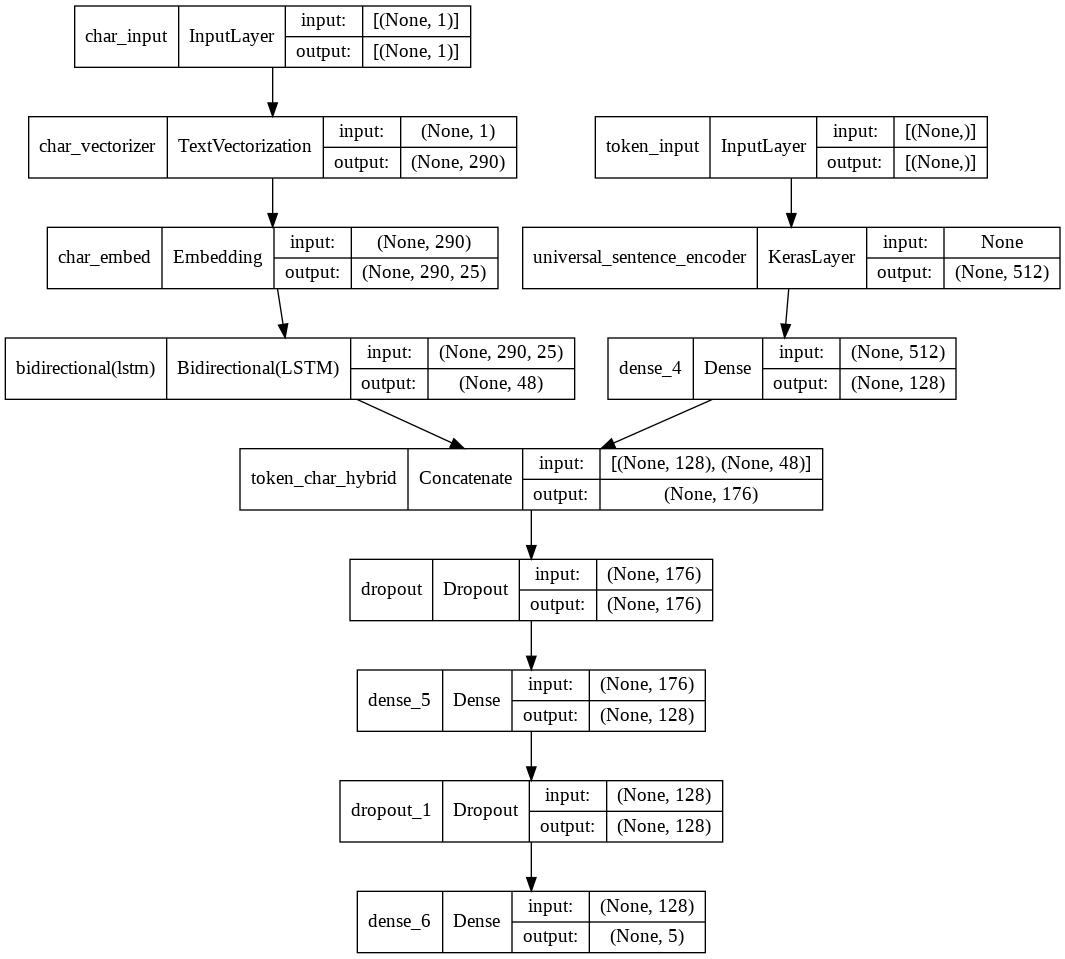

In [90]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

#### Compile the hybrid model

In [91]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Combining token and Character data to tf.data Dataset

In [92]:
# Combine Chars and token into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels =  tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset =  tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset= train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [93]:
# Repeat above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels =  tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset =  tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset= val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [94]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

#### Fitting the model on token and character-level sequences

In [95]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)) 
                              )

Epoch 1/3
562/562 [==============================] - 86s 133ms/step - loss: 0.9809 - accuracy: 0.6092 - val_loss: 0.7899 - val_accuracy: 0.6991
Epoch 2/3
562/562 [==============================] - 71s 126ms/step - loss: 0.8084 - accuracy: 0.6886 - val_loss: 0.7297 - val_accuracy: 0.7237
Epoch 3/3
562/562 [==============================] - 69s 122ms/step - loss: 0.7799 - accuracy: 0.7023 - val_loss: 0.7017 - val_accuracy: 0.7347


In [96]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.7060 - accuracy: 0.7316


[0.706010639667511, 0.7315636277198792]

In [ ]:
model_4_pred_probs= model_4.predict(val_char_token_dataset)

In [98]:
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_4_pred)

In [100]:
model_4_results

{'accuracy': 73.15636171057858,
 'f1': 0.7292618714694463,
 'precision': 0.7325561323266866,
 'recall': 0.7315636171057858}

### Model 5: Pretrained token embeddings + charater embeddings + positional embeddings

#### Create positional embeddings

In [101]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [102]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

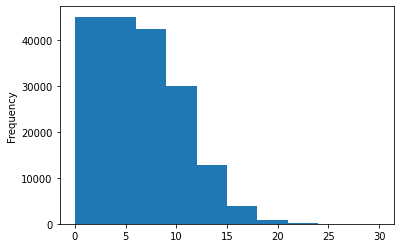

In [103]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [104]:
# Use tensorflow to create one-hot-encoded tensors of our "line_number" column

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10] , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

As we've encoded line number feature lets do the same for total lines feature...

In [105]:
# Ho wmany diff number od line are there
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

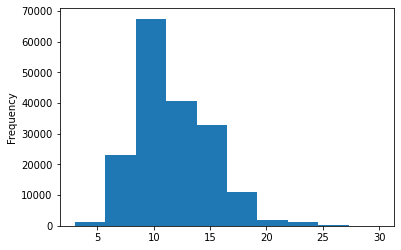

In [106]:
# Lets check distribution
train_df.total_lines.plot.hist();

In [107]:
# Check the coverage of a "total_lines" bvalue of 20
np.percentile(train_df.total_lines, 98)

20.0

In [108]:
# Let's use tensorflow to one-hot-encode total_lines column

train_total_line_one_hot = tf.one_hot(train_df.total_lines.to_numpy(),depth=20)
val_total_line_one_hot = tf.one_hot(val_df.total_lines.to_numpy(),depth=20)
test_total_line_one_hot = tf.one_hot(test_df.total_lines.to_numpy(),depth=20)
train_total_line_one_hot[:10], train_total_line_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building a tribid model

1. Create a token level model
2. Create a charater level model
3. Create  a model for the "line_number" feature
4. create a model for "total_line" feature
5. Conbine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.kears.layers.Concatenate
7. Create an output later to accept the tribid embedding and ouput label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of tf.keras.Model


In [109]:
# 1. Token Inputs

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)

# 2. Char Inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line Numbers
line_numbers_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x= layers.Dense(32, activation="relu")(line_numbers_inputs)
line_number_model = tf.keras.Model(inputs=line_numbers_inputs,
                                   outputs=x)

# 4. Total line model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding

tribid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z])

# 7. Create Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [110]:
# Summary of tribid embediing model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

#### Plot model_5 

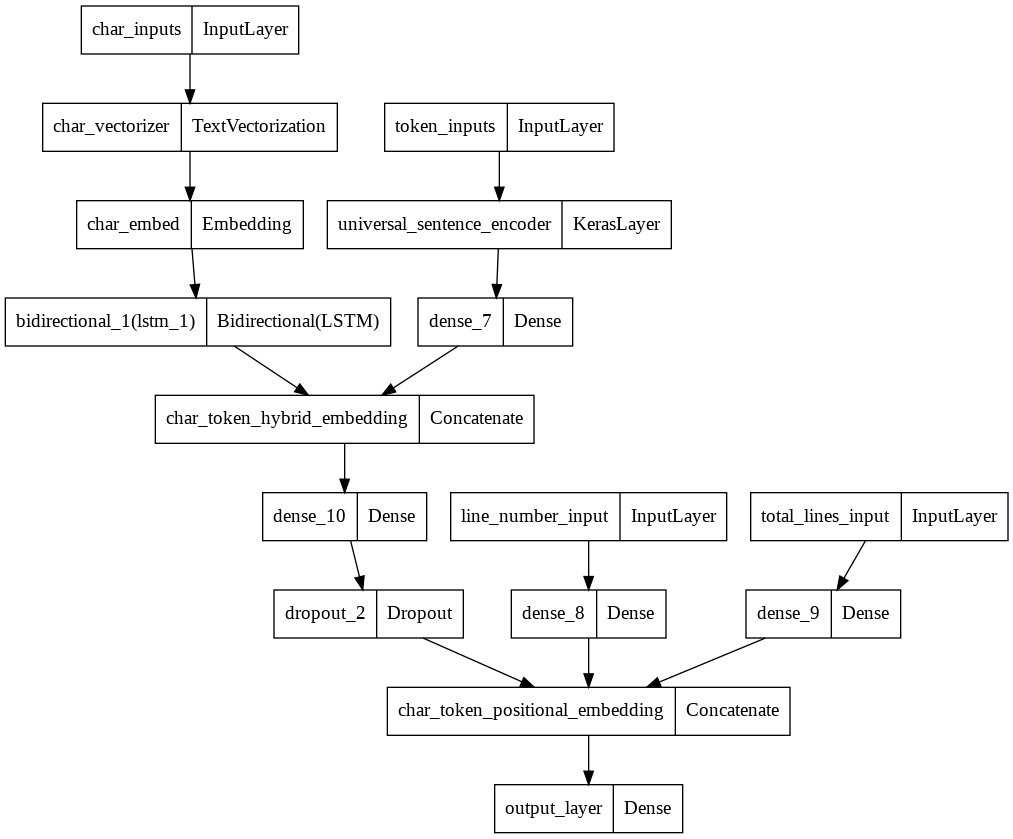

In [111]:
plot_model(model_5)

#### Compile

What is label smooting?

For example, if out model gets too confident on a single class (that is its prediction probablity is really high), it may get stuck on that class and not conisder other classes...

Really Confident: `[0.0, 0.0,1.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes , in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01]`


In [112]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]
                )

#### Creating tribid and validation datasets( with all four kinds of input data)

In [114]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_line_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE) 

# Do the same as above for Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_line_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE) 



In [115]:
# Check input shapes

train_char_token_pos_dataset, train_char_token_pos_dataset 

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

#### Fitting, Evaluating and making predictions with our tribid model

In [116]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 110s 162ms/step - loss: 1.0930 - accuracy: 0.7235 - val_loss: 0.9819 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 84s 149ms/step - loss: 0.9668 - accuracy: 0.8150 - val_loss: 0.9511 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 77s 137ms/step - loss: 0.9506 - accuracy: 0.8240 - val_loss: 0.9418 - val_accuracy: 0.8351


In [118]:
# Make predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 68s 65ms/step


array([[0.52213466, 0.09857035, 0.00993308, 0.35586467, 0.01349724],
       [0.5484858 , 0.10523923, 0.04548947, 0.29249364, 0.00829179],
       [0.28715968, 0.10307742, 0.12724476, 0.42737994, 0.05513824],
       ...,
       [0.03136471, 0.09742314, 0.03629082, 0.03218465, 0.8027367 ],
       [0.02836833, 0.2888493 , 0.08120902, 0.02690929, 0.57466406],
       [0.20442376, 0.595855  , 0.08885369, 0.03954914, 0.07131845]],
      dtype=float32)

In [119]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [120]:
# Calculate results char token pos model
model_5_results =  calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_5_preds)
model_5_results

{'accuracy': 83.28809744472395,
 'f1': 0.8320684301253242,
 'precision': 0.8321339605648799,
 'recall': 0.8328809744472395}

### Compare all model results

In [121]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_wembedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.488680,0.781486,0.784887,0.782292
model_2_pretrained_token_embedding,71.461671,0.715032,0.714617,0.711497
model_3_custom_char_embedding,44.982126,0.377415,0.449821,0.395012
model_4_hybrid_char_token_wembedding,73.156362,0.732556,0.731564,0.729262
model_5_pos_char_token_embedding,83.288097,0.832134,0.832881,0.832068


In [122]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] =  all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.784887,0.781486,0.784887,0.782292
model_2_pretrained_token_embedding,0.714617,0.715032,0.714617,0.711497
model_3_custom_char_embedding,0.449821,0.377415,0.449821,0.395012
model_4_hybrid_char_token_wembedding,0.731564,0.732556,0.731564,0.729262
model_5_pos_char_token_embedding,0.832881,0.832134,0.832881,0.832068


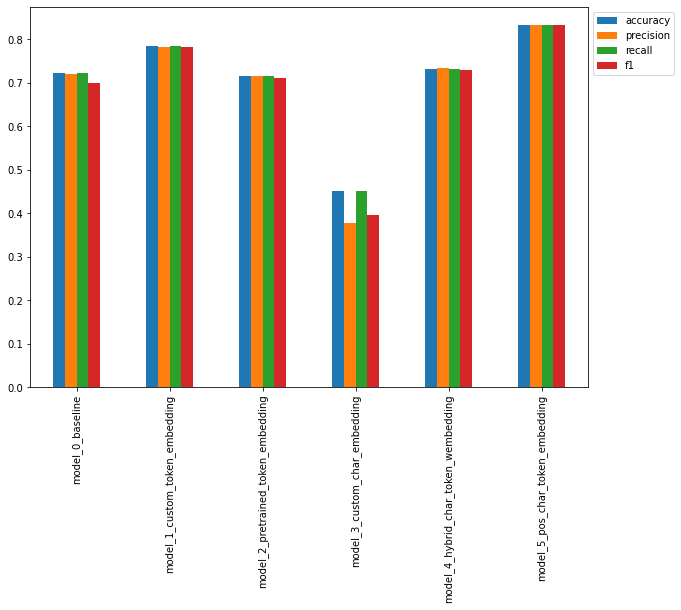

In [125]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

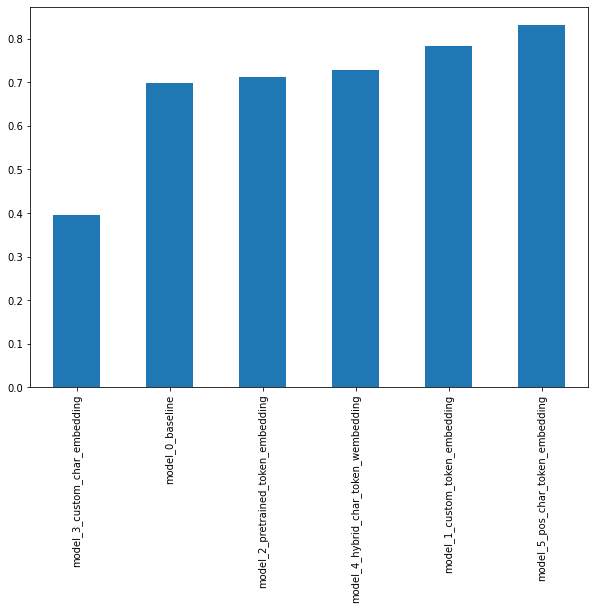

In [126]:
# Sort all models by f1-score (combines precision and recall and good overall metrc for classi fication models)
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));

### Save and load model

In [127]:
# Save the best performing model to SaveModel Format 
model_5.save("skimlit_tribid_model")

INFO:tensorflow:Assets written to: skimlit_tribid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribid_model/assets


In [129]:
# Load the best performing model


In [ ]:
# Make predictions with loaded model